In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from cebra import CEBRA
from PIL import Image
import cv2
import torch
import pickle

In [2]:
with open('feature_labels', 'rb') as f:
    behav_feature = pickle.load(f)

In [4]:
from logging import exception
def process_brain(path):
  try:
    brain_seq = cv2.imreadmulti(path)[1]
    brain_seq = np.array(brain_seq)
    brain_mask = (np.sum(brain_seq, axis=0) > 0)
    flat_seq = (brain_seq[:, brain_mask])
    return flat_seq.astype(float)
  except:
    print(np.shape(brain_seq))

In [5]:
# iterate through all brain data and process it
#https://stackoverflow.com/questions/10377998/how-can-i-iterate-over-files-in-a-given-directory
import os
neural_data = []
name_data = []
behav_data = []

filepath = "2020_11_9_MV1_run_brain"
for file in os.listdir(filepath):
     filename = os.fsdecode(file)
     if filename.endswith(".tif"):
         neural_data.append(process_brain(filepath + '/' + filename))
         name_data.append(filename)
         split_name = filename.split('_')
         session_data = []
         session_data.append(int(split_name[2].split('.')[0]))
         session_data.append(int(split_name[1]))
         behav_data.append(session_data)
         continue
     else:
         continue

In [6]:
multi_cebra_model = CEBRA.load('cebra_multi_model.pt')

In [8]:
image_data = []
filepath = "2020_11_9_MV1_run_behavior"
for file in os.listdir(filepath):
     filename = os.fsdecode(file)
     if filename.endswith(".tif"):
         image_data.append(cv2.imreadmulti(filepath + '/' + filename)[1])
         continue
     else:
         continue

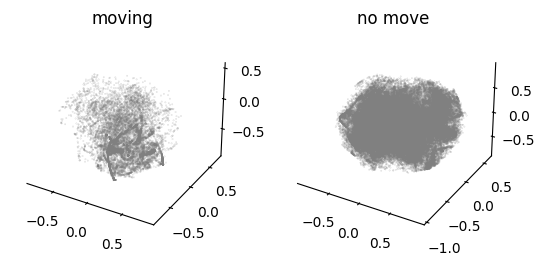

In [73]:

import cebra
fig = plt.figure()
move_nomove = []
ax1 = plt.subplot(121, projection='3d')
ax2 = plt.subplot(122, projection='3d')
index = 20
for run, data in enumerate(zip(neural_data, name_data)):
  is_move = True
  if data[1].split('_')[0] == 'move':
    is_move = True
    move_nomove.append(np.ones_like(data[0][:, 1]))
  else:
    is_move = False
    move_nomove.append(np.zeros_like(data[0][:, 1]))
  embedding = multi_cebra_model.transform(data[0], session_id=run)
  if is_move:
    ax1 = cebra.plot_embedding(embedding, idx_order=(5,6, 7), ax=ax1, title='moving')
  else:
    ax2 = cebra.plot_embedding(embedding, ax=ax2, title = 'no move')

plt.show()

In [38]:
move_embedding = []
for run, data in enumerate(neural_data):
    move_embedding.append(multi_cebra_model.transform(data, session_id=run))

In [61]:
print(np.shape(move_embedding[1]))
print(np.shape(move_nomove[1]))
move_embeddings_flat = move_embedding[0]
move_move_nomove_flat = move_nomove[0]
for data in zip(move_embedding[1::], move_nomove[1::]):
    move_embeddings_flat = np.concatenate((move_embeddings_flat, data[0]))
    move_move_nomove_flat = np.concatenate((move_move_nomove_flat, data[1]))

(184, 8)
(184,)
[[-0.43883175 -0.32548341  0.26442823 ...  0.19093722 -0.23949651
   0.12202358]
 [-0.46613133 -0.25768995  0.2275475  ...  0.18792066 -0.34516409
   0.05757922]
 [-0.37454048 -0.40935126  0.32025251 ...  0.188356   -0.04566959
   0.22289611]
 ...
 [-0.40026081  0.25574565 -0.09744482 ...  0.07657286 -0.7539677
  -0.41683549]
 [-0.40033475  0.25584328 -0.09734678 ...  0.07672089 -0.75393963
  -0.41674122]
 [-0.40016702  0.255622   -0.09756915 ...  0.07638542 -0.75400329
  -0.41695464]]
[[ 0.35828206 -0.14819022  0.13996108 ... -0.03622546 -0.58937603
   0.57268417]
 [ 0.39298368 -0.13270125  0.18911377 ...  0.06573948 -0.58198255
   0.56987846]
 [ 0.41906738 -0.13598533  0.22940713 ...  0.08755102 -0.5806222
   0.53140259]
 ...
 [ 0.1169714  -0.12507366  0.02507849 ... -0.27308309 -0.67348301
   0.40782189]
 [ 0.12364928 -0.12938437  0.04061899 ... -0.26640564 -0.66459799
   0.4123652 ]
 [ 0.13220003 -0.13470283  0.0583229  ... -0.25874329 -0.65355015
   0.41788042]]
[[

In [65]:
print(np.shape(move_embeddings_flat))
print(np.shape(move_move_nomove_flat))

(99248, 8)
(99248,)


In [68]:
import sklearn.metrics
move_decoder = cebra.KNNDecoder(n_neighbors=36, metric="cosine")
move_decoder.fit(move_embeddings_flat, move_move_nomove_flat)
move_pred = move_decoder.predict(move_embeddings_flat)
test_score = sklearn.metrics.r2_score(move_move_nomove_flat, move_pred)


In [69]:
test_score

0.8896312759925342

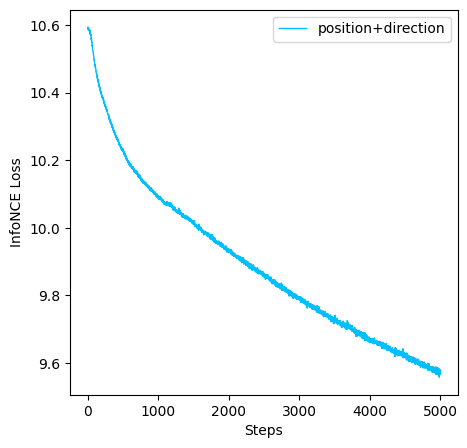

In [74]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)

ax = cebra.plot_loss(multi_cebra_model, color='deepskyblue', label='position+direction', ax=ax)
plt.show()